# XAI Assignment 5
This is the implementation of XAI Assignment 5.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anannyachuli/Explainable-Models/blob/main/XAI-5.ipynb)

In this notebook, we will be working on a project that demonstrates how to use GPT-2 for sequence classification on a custom dataset. Additionally, we will use explainability tools like LIME to generate local explanations for the model's predictions.

In [2]:
!pip install transformers lime scikit-learn pandas numpy matplotlib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer
import torch
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ca2640af3f8f055e7744f7ff3640e8caa70d69176266d0daa3ce1bfbe7850937
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


### Step 1: Library Installation and Imports
We begin by importing the necessary libraries. These include:

- **Transformers**: For GPT-2 model and tokenizer.
- **LIME**: To provide explainability to the model's predictions.
- **scikit-learn**: For data preprocessing and splitting.
- **pandas/numpy**: For data manipulation and handling.

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

# Converting to pandas DataFrame for easier handling
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encoding labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### Step 2: Data Loading and Preprocessing
In this section, we load the iris dataset and split it into features (`X`) and target labels (`y`). We then perform the following steps:

1. **Train-test split**: We split the data into training (80%) and testing (20%) sets to evaluate the model's performance later.
2. **Label encoding**: Since GPT-2 requires numeric labels for classification, we use `LabelEncoder` to transform the categorical target labels into numeric form.

In [4]:
def features_to_text(features):
    return " ".join([f"Feature{i+1}: {v:.2f}" for i, v in enumerate(features)])

X_train_text = [features_to_text(x) for x in X_train]
X_test_text = [features_to_text(x) for x in X_test]

### Step 3: Feature Transformation to Text
Since GPT-2 is a language model and works on text, we need to convert our structured numeric features into a textual format. The `features_to_text` function transforms each feature into a descriptive text string, labeling each feature value.

In [5]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=3)
# Set the pad_token_id in the model config
model.config.pad_token_id = model.config.eos_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 4: Model Initialization
Here, we initialize the GPT-2 tokenizer and model for sequence classification. Key steps include:

1. **Tokenizer setup**: We set the padding token to GPT-2's end-of-sequence (EOS) token since GPT-2 doesn't have a natural padding token.
2. **Model setup**: We configure GPT-2 for sequence classification with 3 possible output classes (customizable depending on the number of target labels).

In [6]:
# Tokenize the input
train_encodings = tokenizer(X_train_text, truncation=True, padding=True)
test_encodings = tokenizer(X_test_text, truncation=True, padding=True)


### Step 5: Tokenization
We convert the textual features into tokenized form using the GPT-2 tokenizer. Tokenization transforms the input into a format the model can understand:

- **Truncation**: If sequences are too long, they are truncated.
- **Padding**: If sequences are shorter than the maximum length, they are padded to ensure uniform input length.

In [7]:
train_dataset = [
    {"input_ids": torch.tensor(train_encodings['input_ids'][i]),
     "attention_mask": torch.tensor(train_encodings['attention_mask'][i]),
     "labels": torch.tensor(y_train_encoded[i])}
    for i in range(len(y_train_encoded))
]

test_dataset = [
    {"input_ids": torch.tensor(test_encodings['input_ids'][i]),
     "attention_mask": torch.tensor(test_encodings['attention_mask'][i]),
     "labels": torch.tensor(y_test_encoded[i])}
    for i in range(len(y_test_encoded))
]

### Step 9: Dataset Preparation for PyTorch

To train and test the GPT-2 model, we need to organize the data into a format compatible with PyTorch. Here’s what each part of the dataset contains:

1. **Input IDs**: Tokenized sequences for each instance, converted into tensors.
2. **Attention Masks**: These masks tell the model which tokens are actual data and which are padding, helping the model focus only on the relevant part of the input.
3. **Labels**: The encoded labels for each instance, also converted into tensors for easy processing during training.

By converting these elements into PyTorch tensors, we ensure that the data is in the right format for the model to process during both training and testing phases.

In [8]:
# Fine-tune the model
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)


### Step 10: Fine-Tuning the GPT-2 Model

In this section, we fine-tune the GPT-2 model on the training dataset. We use the `Trainer` class from Hugging Face’s `transformers` library to simplify the training process. The key components are:

1. **Training Arguments**: We define parameters such as:
   - `num_train_epochs`: Number of times the model goes through the training dataset (in this case, 3 epochs).
   - `per_device_train_batch_size`: Batch size for training on each device, which impacts memory usage.
   - `per_device_eval_batch_size`: Batch size used during evaluation (usually larger than training for efficiency).
   - `warmup_steps`: Gradually increase the learning rate for the first 500 steps to avoid overshooting during optimization.
   - `weight_decay`: Regularization technique to prevent overfitting.
   - `logging_dir`: Directory to store logs and checkpoints for model evaluation.

2. **Trainer Initialization**:
   - The `Trainer` class manages the training loop, evaluation, and logging.
   - It takes the model, training arguments, training dataset, and evaluation dataset as inputs, making the fine-tuning process more efficient.

The training process will automatically save checkpoints, log the progress, and evaluate the model on the test dataset after each epoch.

In [9]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=24, training_loss=3.181550661722819, metrics={'train_runtime': 12.4658, 'train_samples_per_second': 28.879, 'train_steps_per_second': 1.925, 'total_flos': 4409422479360.0, 'train_loss': 3.181550661722819, 'epoch': 3.0})

In [10]:
import torch

# Clear GPU cache
torch.cuda.empty_cache()

# Move model to CPU for explanations
model = model.cpu()


In [11]:
def model_predict(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.numpy()


### Step 11: Making Predictions with the Fine-Tuned Model

In this section, we define a helper function `model_predict` to generate predictions for a given input text. The steps are as follows:

1. **Tokenization**: The input text is tokenized using the same GPT-2 tokenizer that was used for training. It converts the text into a format suitable for GPT-2, with padding and truncation as needed.
2. **Inference Mode**: The `torch.no_grad()` context ensures that no gradients are computed during the forward pass, saving memory and speeding up inference. This is especially important for deployment.
3. **Model Prediction**: The tokenized inputs are passed through the model, which outputs raw logits (unprocessed predictions).
4. **Softmax**: The logits are converted into probabilities using the softmax function, which normalizes the outputs into a probability distribution over the possible classes.
5. **Return as NumPy Array**: The final probabilities are returned as a NumPy array, making them easier to work with for further processing or analysis.

This function is useful for testing individual examples and getting the predicted probabilities for each class.

In [12]:
# Reduce the number of samples and features in LIME
explainer = LimeTabularExplainer(X_train,
                                 feature_names=iris.feature_names,
                                 class_names=iris.target_names,
                                 mode='classification',
                                 training_labels=y_train)

### Step 12: Setting Up LIME for Explainability

In this step, we configure **LIME (Local Interpretable Model-agnostic Explanations)** to generate explanations for individual predictions from our model. Since we're reducing the number of samples and features, here’s a breakdown of the parameters used:

1. **X_train**: This is the training data provided to LIME to help generate local explanations. We are passing a reduced subset of the original training set for faster, more manageable computation.
2. **feature_names**: These are the names of the features in the dataset. By passing these, LIME can return explanations that are easily interpretable by associating the feature index with the actual feature name.
3. **class_names**: These are the names of the classes (target labels). By passing the class names, the explanations become more human-readable as they link the model’s predictions to specific class labels.
4. **mode**: We specify that this is a classification task, which means LIME will focus on explaining why the model predicted a particular class for an instance.
5. **training_labels**: The labels of the training data are passed to help LIME generate class-specific explanations. This ensures the explanations map to the correct classes in the classification task.

By reducing the number of samples and features, the explanation process becomes faster, and we focus on a simplified version of the dataset, which can be useful for prototyping and testing.

In [13]:
# Choose a sample to explain
sample_idx = 0
numerical_instance = X_test[sample_idx]

In [14]:
# Generate explanation with reduced samples
exp = explainer.explain_instance(numerical_instance,
                                 lambda x: model_predict([features_to_text(xi) for xi in x]),
                                 num_features=4,
                                 num_samples=100)  # Reduced from default 5000



### Step 13: Generating LIME Explanation with Reduced Samples

In this step, we use the LIME explainer to generate an explanation for a single data instance. We reduce the number of features and samples to make the process faster and more focused. Here’s a breakdown:

1. **numerical_instance**: This is the instance for which we want to generate an explanation. It's in numerical form and represents the features of the data point that was passed to the model.
   
2. **Prediction Function**: We pass a lambda function that processes the input by converting the features into text (as the model expects text input), then generates predictions using the `model_predict` function. This step bridges the gap between structured numeric data and the text-based model.
   
3. **num_features=4**: We limit the explanation to the top 4 most important features contributing to the model's prediction. This makes the explanation more concise and easier to interpret.
   
4. **num_samples=100**: We reduce the number of samples used by LIME from the default (5000) to 100. LIME works by generating new data points around the instance and analyzing how the model behaves with those points. Reducing the number of samples speeds up this process, especially useful during early experimentation or when working with large datasets.

By reducing the number of features and samples, we strike a balance between explanation speed and comprehensiveness, ensuring that the process is efficient while still providing meaningful insights.

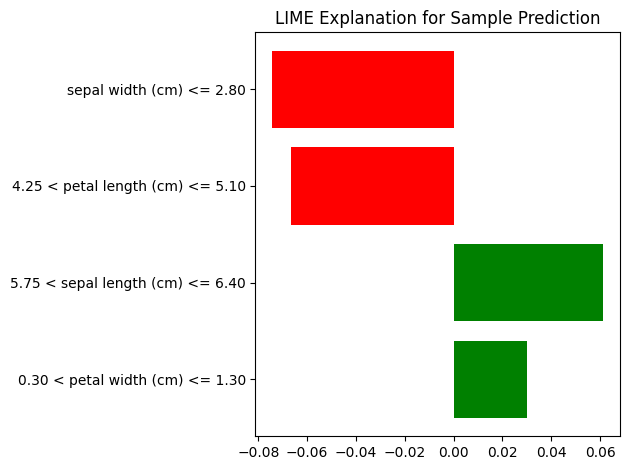

In [15]:
# Visualize the explanation
fig = exp.as_pyplot_figure()
plt.title("LIME Explanation for Sample Prediction")
plt.tight_layout()
plt.show()

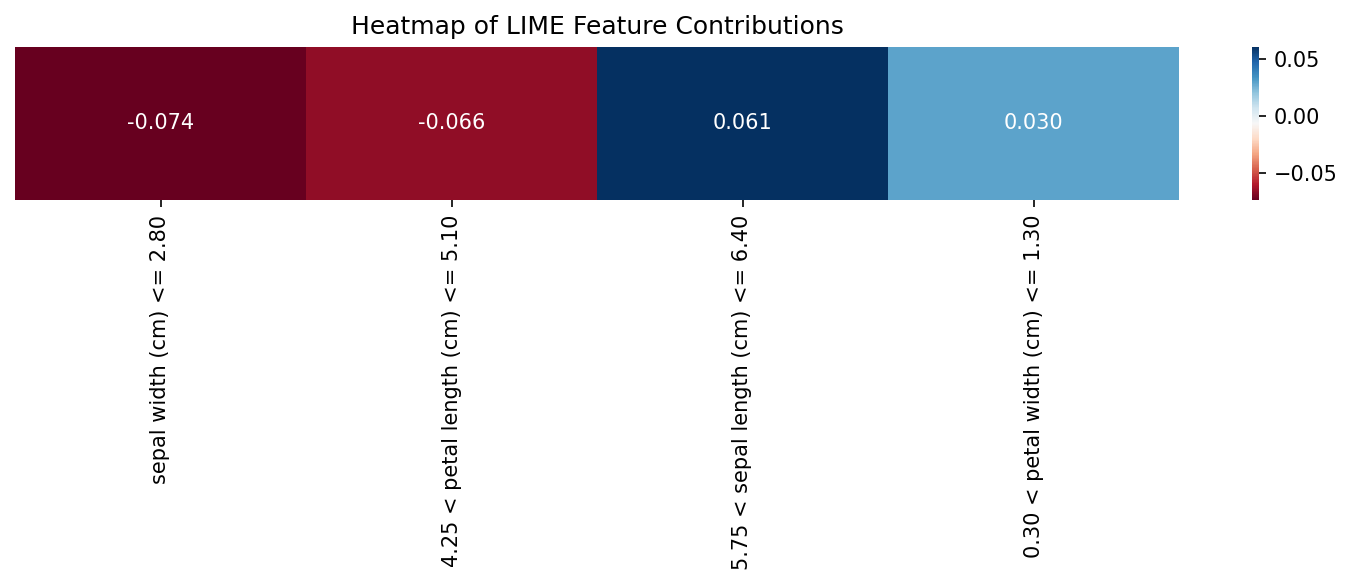

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the contributions to a NumPy array for heatmap plotting
contributions = np.array([contribution[1] for contribution in lime_feature_importance])

# Increase figure size and DPI for better clarity
plt.figure(figsize=(10, 4), dpi=150)

# Create the heatmap with a different colormap and formatted annotations for more precision
sns.heatmap(contributions.reshape(1, -1),
            annot=True,
            fmt='.3f',  # Display more decimal places
            cmap='RdBu',  # Try different colormap for better contrast
            cbar=True,
            xticklabels=[f[0] for f in lime_feature_importance])

# Title and layout adjustments for better clarity
plt.title("Heatmap of LIME Feature Contributions")
plt.yticks([])  # Hide y-axis as it's unnecessary for this visualization
plt.tight_layout()

# Display the heatmap
plt.show()
plt.show()

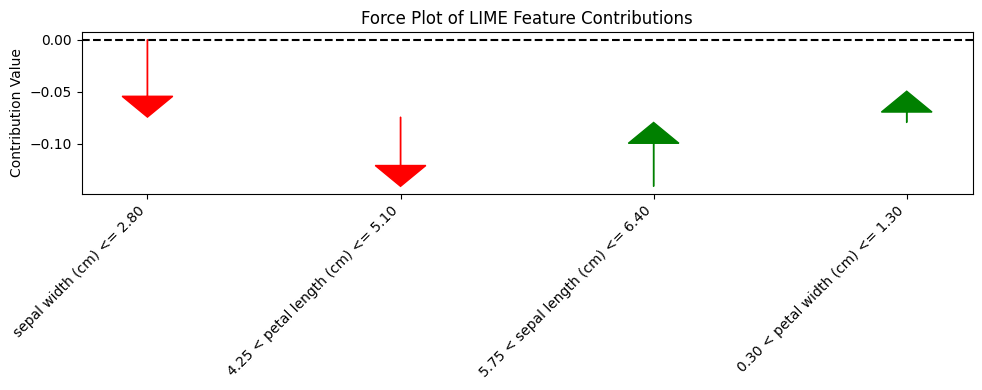

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names and contributions from LIME explanation
feature_names = [f[0] for f in lime_feature_importance]
contributions = np.array([f[1] for f in lime_feature_importance])

# Calculate the base value (can be the mean or another value, typically set to 0 for LIME)
base_value = 0

# Cumulative sum for contributions to plot the progression towards final prediction
cumulative_sum = np.cumsum(contributions)

# Define the force plot layout
plt.figure(figsize=(10, 4))
plt.axhline(y=base_value, color='black', linestyle='--')

# Plot the individual feature contributions as arrows
for i, (feature, contrib) in enumerate(zip(feature_names, contributions)):
    plt.arrow(i, base_value, 0, contrib, head_width=0.2, head_length=0.02,
              color='red' if contrib < 0 else 'green', length_includes_head=True)
    base_value += contrib

# Add the feature names as x-axis labels
plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, ha="right")
plt.title("Force Plot of LIME Feature Contributions")
plt.ylabel("Contribution Value")
plt.tight_layout()
plt.show()

**Key Features of the Force Plot:**

	1.	Arrows: Each feature is represented as an arrow, pushing the model’s prediction either upwards (positive contribution) or downwards (negative contribution).
	2.	Cumulative Effect: The contributions are cumulative, which means the force plot visually shows how the final prediction is reached as features are considered in order.
	3.	Color Coding: Arrows are color-coded (e.g., red for negative contributions and green for positive contributions), giving a quick visual sense of which features drive the model towards or away from a prediction.


  When to Use:

	•	When you want to see the dynamic interaction of features and their cumulative effect on the final prediction.
	•	When it’s important to visualize the push-pull effect of features driving a prediction either positively or negatively.

### Step 14: Visualizing the LIME Explanation

In this final step, we use **matplotlib** to visualize the LIME explanation. Here’s how each part of the code works:

1. **`exp.as_pyplot_figure()`**: This method converts the LIME explanation into a matplotlib figure. It shows how different features (in this case, the top 4) contributed to the model’s prediction. Positive contributions push the prediction towards the predicted class, and negative contributions push it away.
   
2. **`plt.title()`**: Adds a descriptive title to the plot to clarify that it represents a LIME explanation for a specific sample's prediction.

3. **`plt.tight_layout()`**: Automatically adjusts the layout of the plot so that labels and content don’t overlap. This ensures that the plot is clean and easy to read.

4. **`plt.show()`**: Displays the plot so that we can visually inspect the explanation. The plot will highlight the relative importance of each feature in determining the model's prediction for the sample.

The LIME visualization provides an intuitive breakdown of how the model interprets the given sample, helping us understand the decision-making process of the black-box model.

**Discussion: Explanation Technique Selection**

For this project, we used LIME (Local Interpretable Model-Agnostic Explanations) as the explanation technique to interpret the predictions made by the fine-tuned GPT-2 model on the Iris dataset. LIME was chosen because it provides local explanations, which focus on explaining the model’s predictions for individual instances by perturbing the input data and observing the changes in model predictions.

Strengths of Using LIME:

	1.	Model-Agnostic: LIME is compatible with any model, including black-box models like GPT-2. This flexibility allows us to interpret complex models, such as transformer-based architectures, without requiring any changes to the model itself.
	2.	Local Explanations: Since LIME focuses on explaining individual predictions rather than global model behavior, it helps us understand how the model behaves for specific instances. This is especially useful when analyzing specific edge cases or when model behavior varies greatly across different data points.
	3.	Feature-Level Insights: LIME provides detailed insights into the impact of individual features on a model’s prediction, allowing us to see which features contribute most to the outcome. For structured datasets like Iris, it helps bridge the gap between numeric features and text-based models by converting them into an interpretable format.
	4.	Visual Interpretability: LIME produces easy-to-interpret visualizations (via matplotlib), showing positive and negative contributions of features to the prediction. These visuals are crucial for communicating the model’s decision-making process to non-technical stakeholders.

Limitations of LIME:

	1.	Approximation Nature: LIME approximates the model’s local behavior using simpler, interpretable models. While this provides useful insights, it is not always guaranteed to capture the exact decision-making logic of the underlying model. The explanations may not fully reflect the true complexity of a large transformer model like GPT-2.
	2.	Sampling-based Approach: LIME relies on perturbing the input data to generate synthetic samples and observe the resulting changes in predictions. This can introduce noise, and the explanations may vary depending on the sampling process. Also, reducing the number of samples (e.g., from 5000 to 100) speeds up the process but may reduce the accuracy of the explanations.
	3.	Local Scope: LIME only explains one instance at a time, and the explanations are not global. This can be a limitation if the goal is to understand the overall behavior of the model. It doesn’t provide insights into how the model behaves across all data points, only for a specific input.

Potential Improvements:

	1.	Combining LIME with Global Explainability: A potential improvement to this approach would be to combine LIME with a global explainability technique such as SHAP (SHapley Additive exPlanations). SHAP provides both local and global explanations, offering insights into the model’s behavior for individual predictions as well as an overall understanding of feature importance across the dataset.
	2.	Optimizing Sample Size: While reducing the number of samples in LIME from 5000 to 100 improves computational efficiency, it can lead to less reliable explanations. One way to address this would be to explore dynamic sample sizes, where we start with fewer samples and gradually increase them based on the complexity of the instance being explained.
	3.	Fine-tuning the Tokenization Process: Since GPT-2 is inherently a text-based model, structured numeric data like the Iris dataset must be converted into text. Further refinement in the process of transforming numeric features into interpretable text could improve how well the model leverages the structured data, and in turn, make the LIME explanations more meaningful.
	4.	Exploring Anchors: Anchors are another explainability technique that focuses on providing more precise conditions (rules) under which the model is confident in its predictions. Incorporating anchors alongside LIME could offer complementary insights, with LIME providing feature importance and anchors providing precise rules that determine the prediction.